# Data Science Challenge

In [1]:
# To install packages that are not installed by default, uncomment the last two lines 
# of this cell and replace <package list> with a list of necessary packages.
# This will ensure the notebook has all the dependencies and works everywhere.

import sys
!{sys.executable} -m pip install folium scikit-plot plotly xgboost graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Import Packages

In [3]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

## Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every hotel.
`region` | The region in which the hotel is located..
`latitude` | The latitude of the hotel.
`longitude` | The longitude of the hotel.
`accommodation_type` | The type of accommodation offered by the hotel. For example: Private room, Entire house/apt, etc.
`cost` | The cost of booking the hotel for one night. (in \$\$)
`minimum_nights` | The minimum number of nights stay required.
`number_of_reviews` | The number of reviews accumulated by the hotel.
`reviews_per_month` | The average number of reviews received by the hotel per month.
`owner_id` | The unique ID assigned to every owner. An owner can own multiple hotels.
`owned_hotels` | The number of hotels owned by the owner.
`yearly_availability` | It indicates if the hotel accepts bookings around the year. Values are 0 (not available for 365 days in a year) and 1 (available for 365 days in a year).

## Data Wrangling & Visualization

In [4]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [5]:
#Let's take a peek at the data
data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1
3,34305,Manhattan,40.73863,-73.98002,Private room,210,30,0,NaN,200380610,65,1
4,444,Manhattan,40.82426,-73.94630,Shared room,75,3,38,0.42,745069,3,1


In [6]:
#Let's look at the shape of the data
rows,columns = data.shape
print('There are {} rows and {} columns in the given dataset'.format(rows,columns))

There are 2870 rows and 12 columns in the given dataset


In [7]:
#Description
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 12 columns):
id                     2870 non-null int64
region                 2870 non-null object
latitude               2870 non-null float64
longitude              2870 non-null float64
accommodation_type     2870 non-null object
cost                   2870 non-null int64
minimum_nights         2870 non-null int64
number_of_reviews      2870 non-null int64
reviews_per_month      2194 non-null float64
owner_id               2870 non-null int64
owned_hotels           2870 non-null int64
yearly_availability    2870 non-null int64
dtypes: float64(3), int64(7), object(2)
memory usage: 269.2+ KB


Findings
We can see that the dataset contains 2 character variables and 11 numerical variables.

yearly_availability is the target variable.

In [8]:
#Look at the statistical properties of the numerical features of the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2870.0,2.676066e+04,1.414093e+04,0.00000,1.593175e+04,2.894650e+04,3.847850e+04,4.889300e+04
latitude,2870.0,4.073122e+01,5.494182e-02,40.50708,4.069246e+01,4.072825e+01,4.076266e+01,4.089873e+01
longitude,2870.0,-7.395016e+01,4.974454e-02,-74.24285,-7.398400e+01,-7.395672e+01,-7.393420e+01,-7.372173e+01
cost,2870.0,1.959432e+02,4.061847e+02,10.00000,7.500000e+01,1.200000e+02,2.000000e+02,9.999000e+03
minimum_nights,2870.0,1.153031e+01,3.797234e+01,1.00000,1.000000e+00,3.000000e+00,6.000000e+00,9.990000e+02
number_of_reviews,2870.0,1.631533e+01,3.248172e+01,0.00000,1.000000e+00,4.000000e+00,1.600000e+01,3.950000e+02
reviews_per_month,2194.0,1.157502e+00,1.355028e+00,0.01000,2.400000e-01,6.500000e-01,1.530000e+00,1.037000e+01
owner_id,2870.0,7.202195e+07,8.076516e+07,2787.00000,7.388002e+06,3.352708e+07,1.207625e+08,2.738123e+08
owned_hotels,2870.0,8.411498e+00,2.710552e+01,1.00000,1.000000e+00,1.000000e+00,3.000000e+00,3.270000e+02
yearly_availability,2870.0,4.986063e-01,5.000852e-01,0.00000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [9]:
#Simple function to perform quick exploratory data analysis
def initial_eda(df):
    total_na = df.isna().sum().sum()
    print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
    print("Total NA Values : %d " % (total_na))
    print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
    col_name = df.columns
    dtyp = df.dtypes
    uniq = df.nunique()
    na_val = df.isna().sum()
    for i in range(len(df.columns)):
        print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))

In [10]:
initial_eda(data)

Dimensions : 2870 rows, 12 columns
Total NA Values : 676 
                           Column Name  Data Type      #Distinct  NA Values
                                    id      int64         2870          0
                                region     object            5          0
                              latitude    float64         2647          0
                             longitude    float64         2550          0
                    accommodation_type     object            3          0
                                  cost      int64          330          0
                        minimum_nights      int64           53          0
                     number_of_reviews      int64          160          0
                     reviews_per_month    float64          419        676
                              owner_id      int64         2371          0
                          owned_hotels      int64           40          0
                   yearly_availability      int64   

In [11]:
#Let's look at percentages of missing value for all the attributes if any
data[data.columns[data.isnull().any()]].isnull().sum() * 100 /data.shape[0]

reviews_per_month    23.554007
dtype: float64

Finidings:
Above table shows that, there are 676 missing values for some reviews_per_months.

In [12]:
#dealing with missing values
# replace na values in review per month variable with `0`
data=data.fillna(0)

In [13]:
#Let's look at percentages of missing value for all the attributes if any
data[data.columns[data.isnull().any()]].isnull().sum() * 100 /data.shape[0]

Series([], dtype: float64)

## Exploring Categorical Variables

In [14]:
#Let's find the categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 2 categorical variables

The categorical variables are :

 ['region', 'accommodation_type']


In [15]:
for var in categorical: 
    
    print(data[var].value_counts())

Manhattan        1333
Brooklyn         1075
Queens            370
Bronx              78
Staten Island      14
Name: region, dtype: int64
Private room       1225
Entire home/apt    1002
Shared room         643
Name: accommodation_type, dtype: int64


### Exploring Region alongwith Latitude and Longitude

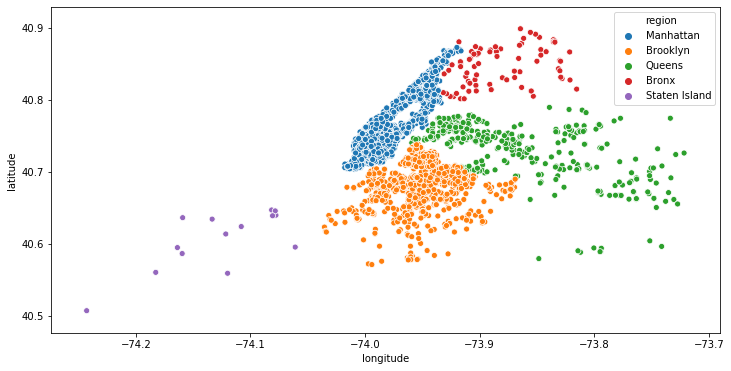

In [16]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = data.longitude,y = data.latitude,hue=data.region)
plt.show()

We can observe the geographic distribution of the hotel rooms

In [17]:
#better interactive visualization of the density of rooms
import folium 
from folium import plugins
from folium.plugins import HeatMap
ny_map = folium.Map(location=[40.7, -74],zoom_start =10)
data_loc= data[['latitude','longitude']].values
data_loc =data_loc.tolist()
hm = plugins.HeatMap(data_loc)
hm.add_to(ny_map)
ny_map

In [18]:
set(data['region'])
{'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'}
data.groupby('region')['yearly_availability'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Bronx,78.0,0.730769,0.446431,0.0,0.0,1.0,1.0,1.0
Brooklyn,1075.0,0.447442,0.497461,0.0,0.0,0.0,1.0,1.0
Manhattan,1333.0,0.488372,0.500052,0.0,0.0,0.0,1.0,1.0
Queens,370.0,0.621622,0.485639,0.0,0.0,1.0,1.0,1.0
Staten Island,14.0,0.857143,0.363137,0.0,1.0,1.0,1.0,1.0


Findings:
    From the above table we can observe how the yearly availability changes based on the region
    Staten Island has very few listings but 85.7% of it's listings are yealry_available
    Only 44% of the listings in Brooklyn are yearly_available
    Looking at this we can say that region will be an important feature to predict the target variable, 'yearly_availability'

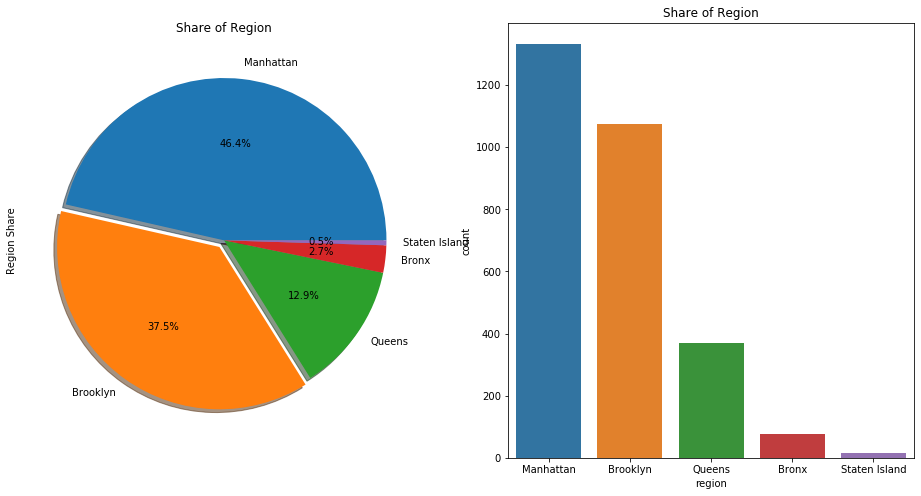

In [19]:
#Let us look at how the data is distributed across different regions
f,ax=plt.subplots(1,2,figsize=(16,8))
data['region'].value_counts().plot.pie(explode=[0,0.05,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Share of Region')
ax[0].set_ylabel('Region Share')
sns.countplot('region',data=data,ax=ax[1],order=data['region'].value_counts().index)
ax[1].set_title('Share of Region')
plt.show()

### Exploring Accomodation Type

In [20]:
#Let's look at how accomodation type is realted to target variable
set(data['accommodation_type'])
{'Private room','Entire home/apt','Shared room',}
data.groupby('accommodation_type')['yearly_availability'].describe()

,count,mean,std,min,25%,50%,75%,max
accommodation_type,,,,,,,,
Entire home/apt,1002.0,0.057884,0.233641,0.0,0.0,0.0,0.0,1.0
Private room,1225.0,0.898776,0.301749,0.0,1.0,1.0,1.0,1.0
Shared room,643.0,0.423017,0.494423,0.0,0.0,0.0,1.0,1.0


Findings:
    From the above table we can observe how the yearly availability changes based on the accomodation_type
    Almost 90% of Private Rooms listings are yealry_available
    Only 0.05% of the Entire Hhomlistings in Brooklyn are yearly_available
    Looking at this we can say that region will be an important feature to predict the target variable, 'yearly_availability'

## Exploring Numerical Varibables

In [21]:
numerical = [var for var in data.columns if data[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 10 numerical variables

The numerical variables are :

 ['id', 'latitude', 'longitude', 'cost', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id', 'owned_hotels', 'yearly_availability']


In [22]:
data[numerical].head()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,40.71854,-74.00439,170,5,7,0.56,929983,1,0
1,246,40.64446,-73.95030,65,3,238,2.30,281764,1,0
2,19091,40.78573,-73.81062,85,1,0,0.00,19923341,1,1
3,34305,40.73863,-73.98002,210,30,0,0.00,200380610,65,1
4,444,40.82426,-73.94630,75,3,38,0.42,745069,3,1


### Let's explore the target vaiable yearly availability 

In [23]:
# view the frequency distribution of values
data['yearly_availability'].value_counts()

0    1439
1    1431
Name: yearly_availability, dtype: int64

In [24]:
# view percentage of frequency distribution of values
data['yearly_availability'].value_counts()/len(data)

0    0.501394
1    0.498606
Name: yearly_availability, dtype: float64

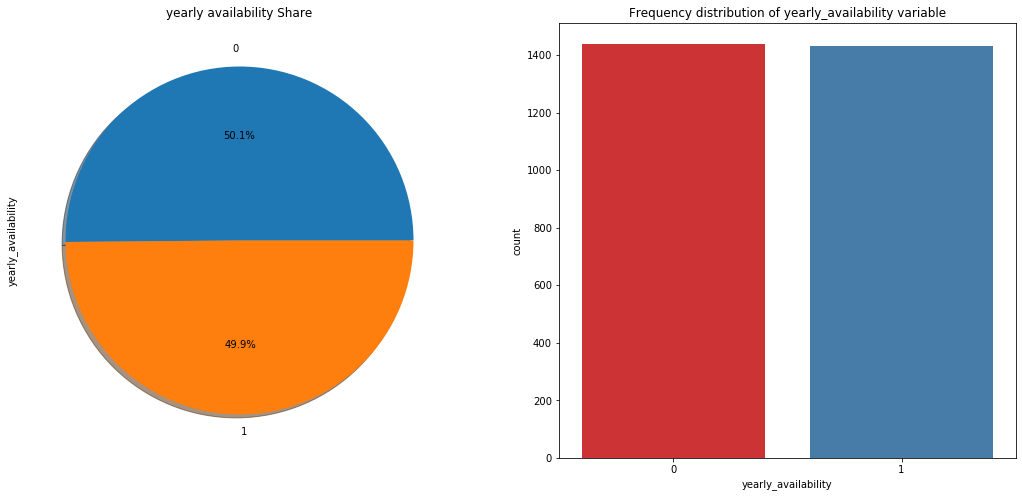

In [25]:
# visualize frequency distribution of yearly availability variable

f,ax=plt.subplots(1,2,figsize=(18,8))
ax[0] = data['yearly_availability'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('yearly availability Share')
#f, ax = plt.subplots(figsize=(6, 8))
ax[1] = sns.countplot(x="yearly_availability", data=data, palette="Set1")
ax[1].set_title("Frequency distribution of yearly_availability variable")
plt.show()

Findings:
    The target variable is more or less equally distributed

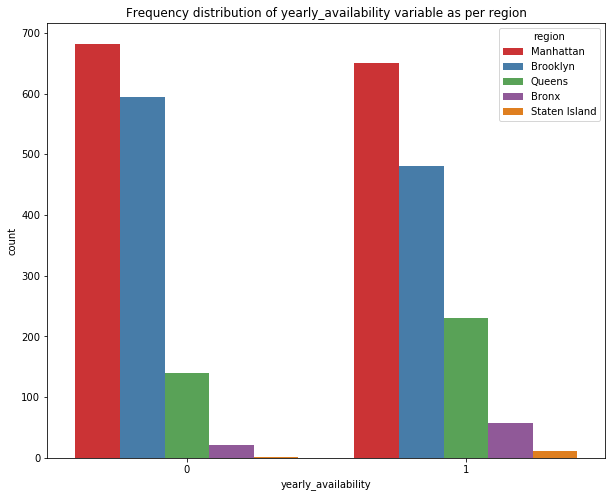

In [26]:
#Visualize target variable as per region
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(x="yearly_availability", hue="region", data=data, palette="Set1")
ax.set_title("Frequency distribution of yearly_availability variable as per region")
plt.show()

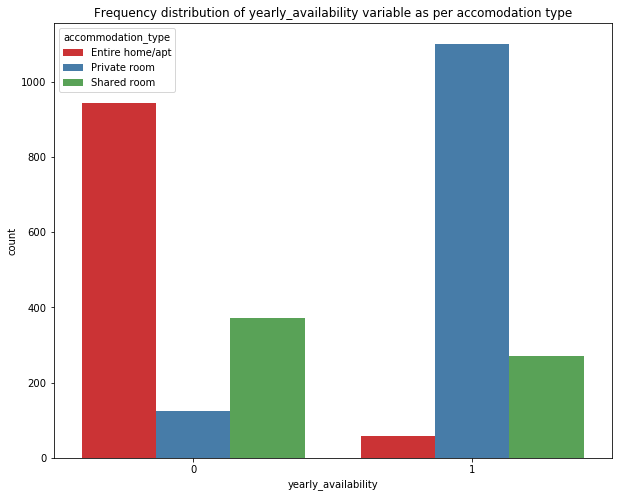

In [27]:
#Visualize target variable as per accomodation type
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.countplot(x="yearly_availability", hue="accommodation_type", data=data, palette="Set1")
ax.set_title("Frequency distribution of yearly_availability variable as per accomodation type")
plt.show()

In [28]:
#Not able to save file if using plotly plots
import plotly.express as px
fig = px.imshow(data.corr())

In [29]:
### Correlation Plot and Multicollinearity
data.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('Blues_r'), axis=1)

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
id,1.0,-0.01603,0.05968,-0.03681,-0.07841,-0.3302,0.146,0.5236,0.02591,-0.1616
latitude,-0.01603,1.0,0.04934,0.009657,0.01061,0.006295,0.01536,-0.009361,0.0641,-0.02512
longitude,0.05968,0.04934,1.0,-0.1361,-0.07486,0.006381,0.05265,0.1429,-0.1425,0.1199
cost,-0.03681,0.009657,-0.1361,1.0,0.05292,-0.07443,-0.1231,-0.04959,0.03219,0.1476
minimum_nights,-0.07841,0.01061,-0.07486,0.05292,1.0,-0.08877,-0.1398,-0.01801,0.1079,0.1736
number_of_reviews,-0.3302,0.006295,0.006381,-0.07443,-0.08877,1.0,0.5766,-0.162,-0.1123,-0.1916
reviews_per_month,0.146,0.01536,0.05265,-0.1231,-0.1398,0.5766,1.0,0.07758,-0.147,-0.3122
owner_id,0.5236,-0.009361,0.1429,-0.04959,-0.01801,-0.162,0.07758,1.0,0.07453,0.1212
owned_hotels,0.02591,0.0641,-0.1425,0.03219,0.1079,-0.1123,-0.147,0.07453,1.0,0.1919
yearly_availability,-0.1616,-0.02512,0.1199,0.1476,0.1736,-0.1916,-0.3122,0.1212,0.1919,1.0


## Visualization, Modeling, Machine Learning

Build a model that categorizes hotels on the basis of their yearly availability.  Identify how different features influence the decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of Accuracy.**
- **Read the test.csv file and prepare features for testing.**

In [30]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,19215,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,36301,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,40566,Manhattan,40.76616,-73.98228,Private room,225,30,0,NaN,13773574,12
3,33694,Manhattan,40.77668,-73.94587,Shared room,125,30,9,0.82,6788748,1
4,28873,Manhattan,40.80279,-73.94450,Entire home/apt,43,1,13,0.72,105061915,2


In [31]:
# Declare feature vector and target variable ¶
X = data.drop(['id','owner_id','yearly_availability'], axis = 1)
y = data['yearly_availability']

In [32]:
#let us look at the variables in the feature vector
categorical = [col for col in X.columns if X[col].dtypes == 'O']
categorical

['region', 'accommodation_type']

In [33]:
numerical = [col for col in X.columns if X[col].dtypes != 'O']
numerical

['latitude',
 'longitude',
 'cost',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'owned_hotels']

### Feature Engineering

In [34]:
def process_product_group(df,cls,groups,prefixs):
    """
    feature engineering:
        load numeric values
        get dummies on categorical
    """
    processed_df = df[cls]
    
    for i, group in enumerate(groups):
    #Get the Dummy variables
        dummies = pd.get_dummies(df[group], prefix=prefixs[i],drop_first = True)
        processed_df = processed_df.join(dummies)
    return processed_df

In [35]:
num_cls = ['latitude','longitude','cost','minimum_nights','number_of_reviews','reviews_per_month','owned_hotels']
cat_groups = ['region','accommodation_type']
prefixs = ['region','acm_type']

In [36]:
X = process_product_group(X,num_cls,cat_groups,prefixs)

In [37]:
num_cls_tets = ['id','latitude','longitude','cost','minimum_nights','number_of_reviews','reviews_per_month','owned_hotels']

In [38]:
test_data = process_product_group(test_data,num_cls_tets,cat_groups,prefixs)

In [39]:
X.head()

,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owned_hotels,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island,acm_type_Private room,acm_type_Shared room
0,40.71854,-74.00439,170,5,7,0.56,1,0,1,0,0,0,0
1,40.64446,-73.95030,65,3,238,2.30,1,1,0,0,0,0,0
2,40.78573,-73.81062,85,1,0,0.00,1,0,0,1,0,1,0
3,40.73863,-73.98002,210,30,0,0.00,65,0,1,0,0,1,0
4,40.82426,-73.94630,75,3,38,0.42,3,0,1,0,0,0,1


We have performed feature cross to get better results when predicting target variable

In [40]:
#Let's split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Base Model using Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.8710801393728222


We can see we have attained an accuracy of 87% using Logistic Regression

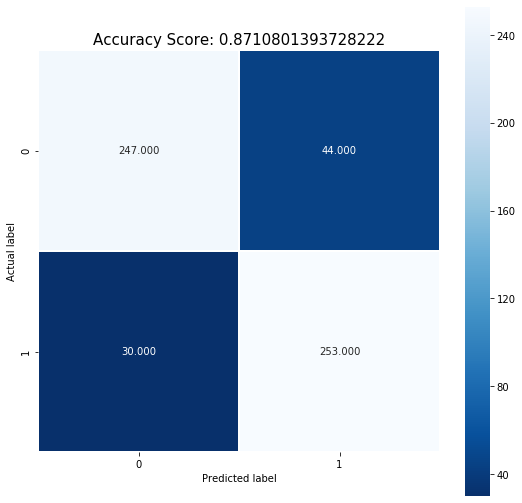

In [43]:
#Let's look at the confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [44]:
#Look at the classification report
print(classification_report(y_test, predictions, digits=6))

              precision    recall  f1-score   support

           0   0.891697  0.848797  0.869718       291
           1   0.851852  0.893993  0.872414       283

    accuracy                       0.871080       574
   macro avg   0.871774  0.871395  0.871066       574
weighted avg   0.872052  0.871080  0.871047       574



We can observe that the model is performing as expected. It is neither underfitting or overfitting

### Random Forest Classifier model with 10 Decision Trees ¶

In [45]:
from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0, n_estimators = 10)
# fit the model
rfc.fit(X_train, y_train)
# Predict the Test set results
y_pred = rfc.predict(X_test)
# Check accuracy score 
from sklearn.metrics import accuracy_score
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.9111


We can see that we have attained an accuracy of 91.11% using default parameters of Random Forest Classifier

### Model Evaluation

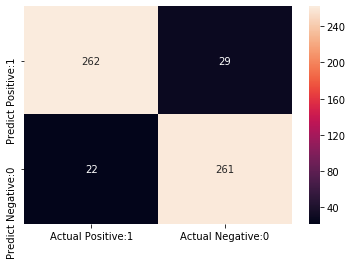

In [46]:
# visualize confusion matrix with seaborn heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

In [47]:
print(classification_report(y_test, y_pred, digits=6))

              precision    recall  f1-score   support

           0   0.922535  0.900344  0.911304       291
           1   0.900000  0.922261  0.910995       283

    accuracy                       0.911150       574
   macro avg   0.911268  0.911303  0.911150       574
weighted avg   0.911425  0.911150  0.911152       574



I will increase the number of decision-trees and see its effect on accuracy.


### Random Forest Classifier model with 50 Decision Trees ¶

In [49]:
rfc_50 = RandomForestClassifier(n_estimators=50, random_state=0)
# fit the model to the training set
rfc_50.fit(X_train, y_train)
# Predict on the test set results
y_pred_50 = rfc_50.predict(X_test)
# Check accuracy score 
print('Model accuracy score with 50 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_50)))

Model accuracy score with 50 decision-trees : 0.9164


We can see that we have attained only a minor bump in accuracy hence, we will use RFC with 10 trees instead to prevent overfitting

### Model Evaluation

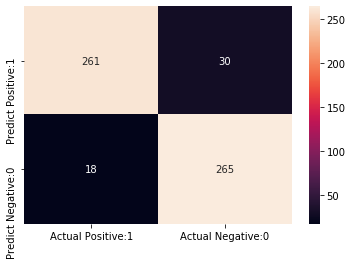

In [50]:
# visualize confusion matrix with seaborn heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_50)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

In [51]:
print(classification_report(y_test, y_pred_50, digits=6))

              precision    recall  f1-score   support

           0   0.935484  0.896907  0.915789       291
           1   0.898305  0.936396  0.916955       283

    accuracy                       0.916376       574
   macro avg   0.916894  0.916651  0.916372       574
weighted avg   0.917154  0.916376  0.916364       574



### XGBoost Classifier

In [53]:
import xgboost as xgb

In [74]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",label_encoder=False, n_estimators=10, random_state=42, eval_metric=["auc", "error", "error@0.6"])

In [75]:
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[17:46:10] WARNING: ../src/learner.cc:576: 
Parameters: { "label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.94983	validation_0-error:0.08537	validation_0-error@0.6:0.08885
[1]	validation_0-auc:0.95375	validation_0-error:0.08188	validation_0-error@0.6:0.08188
[2]	validation_0-auc:0.95631	validation_0-error:0.08014	validation_0-error@0.6:0.08188
[3]	validation_0-auc:0.95726	validation_0-error:0.08014	validation_0-error@0.6:0.08188
[4]	validation_0-auc:0.96411	validation_0-error:0.08188	validation_0-error@0.6:0.07491
[5]	validation_0-auc:0.96398	validation_0-error:0.07666	validation_0-error@0.6:0.07666
[6]	validation_0-auc:0.96469	validation_0-error:0.07666	validation_0-error@0.6:0.08014
[7]	validation_0-auc:0.9635

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric=['auc', 'error', 'error@0.6'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              label_encoder=False, learning_rate=0.300000012, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, ...)

### Model Evaluation

In [76]:
y_pred = xgb_model.predict(X_test)
print('Model accuracy score with 10 estimators : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 estimators : 0.9216


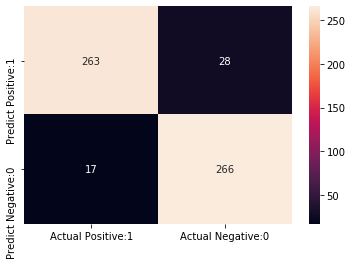

In [77]:
# visualize confusion matrix with seaborn heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

In [78]:
print(classification_report(y_test, y_pred, digits=6))

              precision    recall  f1-score   support

           0   0.939286  0.903780  0.921191       291
           1   0.904762  0.939929  0.922010       283

    accuracy                       0.921603       574
   macro avg   0.922024  0.921855  0.921601       574
weighted avg   0.922264  0.921603  0.921595       574



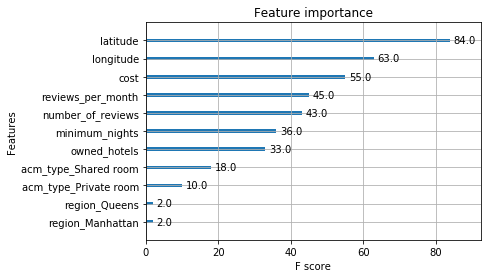

In [79]:
xgb.plot_importance(xgb_model)

We can observe that XGBoost offers the highest accuracy but it is often prone to overfitting hence, we will use RFC for generalizing better



**Highlight the most important features of the model for management.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


In [61]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
# fit the model to the training set
clf.fit(X_train, y_train)
# view the feature scores
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

acm_type_Private room    0.366665
owned_hotels             0.152604
reviews_per_month        0.091677
number_of_reviews        0.069380
acm_type_Shared room     0.064839
cost                     0.063005
minimum_nights           0.060784
longitude                0.059391
latitude                 0.056090
region_Queens            0.005631
region_Manhattan         0.005306
region_Brooklyn          0.004475
region_Staten Island     0.000153
dtype: float64

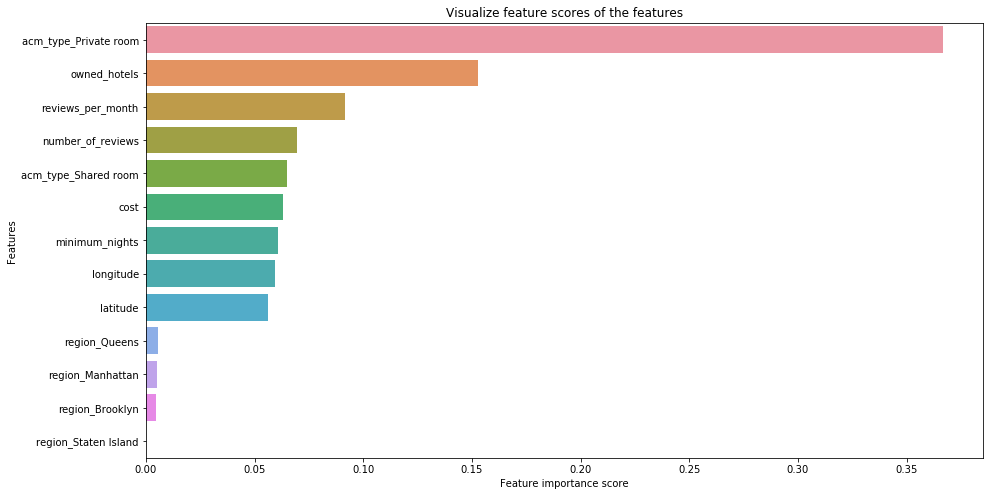

In [64]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=data)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

Key Findings:
    The above plot visualized the top features that help to predict the target variable.
    As we had discussed during EDA, whether or not it is a private room is the most important feature
    The least important feature is whether or not it is in Staten Island region

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `yearly_availability` variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **yearly_availability**

In [80]:
test_data = test_data.fillna(0)
features_to_use = X_train.columns
test_data['yearly_availability'] = rfc.predict(test_data[features_to_use])

In [81]:
test_data.head()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owned_hotels,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island,acm_type_Private room,acm_type_Shared room,yearly_availability
0,19215,40.70912,-73.94513,135,2,22,0.66,1,1,0,0,0,0,1,0
1,36301,40.57646,-73.96641,69,2,8,0.90,2,1,0,0,0,0,0,0
2,40566,40.76616,-73.98228,225,30,0,0.00,12,0,1,0,0,1,0,1
3,33694,40.77668,-73.94587,125,30,9,0.82,1,0,1,0,0,0,1,0
4,28873,40.80279,-73.94450,43,1,13,0.72,2,0,1,0,0,0,0,0


In [82]:
submission_df = test_data[['id','yearly_availability']]

In [83]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

---